In [12]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import common_utils
import stacked_vae_lib

# Load data

In [2]:
seed = 9033

In [3]:
np.random.seed(seed)
_ = torch.manual_seed(seed)

# LOAD DATA
print('Loading data')
_, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample = 1.0,
                                                    propn_labeled = 0.0)


train_loader = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=100,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=100,
                shuffle=False)

Loading data


In [5]:
seed = 4353

np.random.seed(seed)
_ = torch.manual_seed(seed)

for batch_idx, d in enumerate(train_loader):
    train_data = d
    break
    
for batch_idx, d in enumerate(test_loader):
    test_data = d
    break

In [6]:
assert np.all(train_data['image'].detach().numpy() <= 1)

In [7]:
assert np.all(train_data['image'].detach().numpy() >= 0)

In [8]:
np.min(train_data['image'].detach().numpy())

0.0

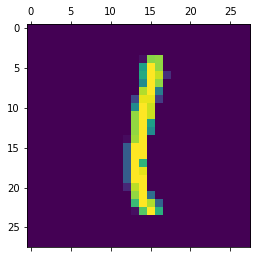

In [9]:
plt.matshow(train_data['image'][0, :, :])

In [10]:
slen = train_data['image'].shape[-1]

# Define VAE

In [15]:
latent_dim = 36
n_classes = 10

In [16]:
vae = stacked_vae_lib.Model1VAE(latent_dim = latent_dim)

In [18]:
# Load results

file_base = '../mnist_vae_results_aws/model1_results/mnist_model1_vae'

enc_file = file_base + '_enc_final'
dec_file = file_base + '_dec_final'

# enc_file = "../mnist_vae_results_aws/mnist_vae_semisuper_reinforce_simple_baseline_enc_final"
# dec_file = '../mnist_vae_results_aws/mnist_vae_semisuper_reinforce_simple_baseline_dec_final'
# classifier_file = '../mnist_vae_results_aws/mnist_vae_semisuper_reinforce_simple_baseline_classifier_final'


vae.encoder.load_state_dict(torch.load(enc_file,
                               map_location=lambda storage, loc: storage))

vae.decoder.load_state_dict(torch.load(dec_file,
                               map_location=lambda storage, loc: storage))


vae.eval()

Model1VAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=72, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=36, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=256, bias=True)
    (fc4): Linear(in_features=256, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
)

# Check losses

In [19]:
loss_array = np.loadtxt(file_base + 'loss_array.txt')

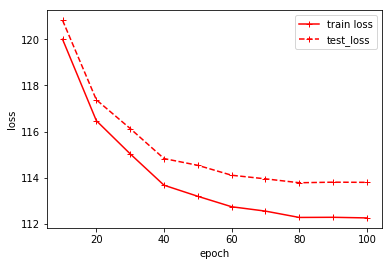

In [20]:
# plot losses
start_indx = 1

plt.plot(loss_array[0, start_indx:], loss_array[1, start_indx:], 'r-+')
plt.plot(loss_array[0, start_indx:], loss_array[2, start_indx:], 'r--+')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(('train loss', 'test_loss'))

In [22]:
# plot trianing accuracy
# plt.plot(loss_array[0, start_indx:], loss_array[3, start_indx:], 'r-+')
# plt.plot(loss_array[0, start_indx:], loss_array[4, start_indx:], 'r--+')

# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.legend(('train', 'test'))

In [26]:
vae.loss(train_data['image'])

tensor(111.0443)

In [27]:
vae.loss(test_data['image'])

tensor(111.6863)

# Check reconstructions

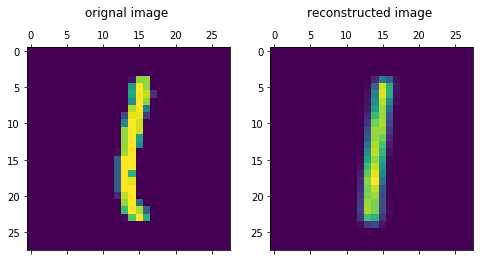

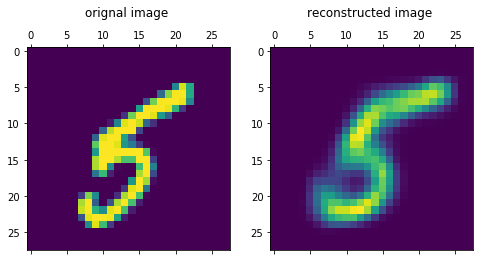

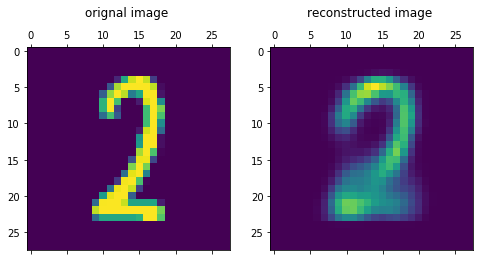

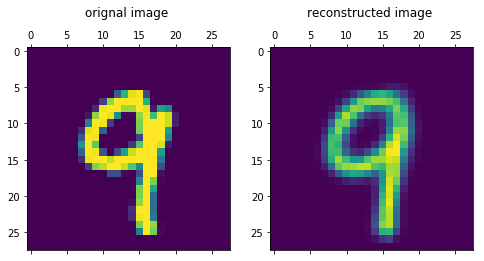

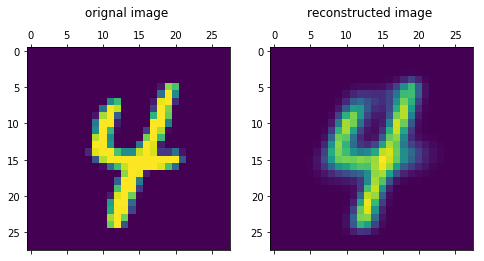

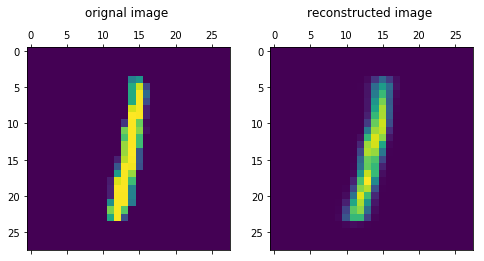

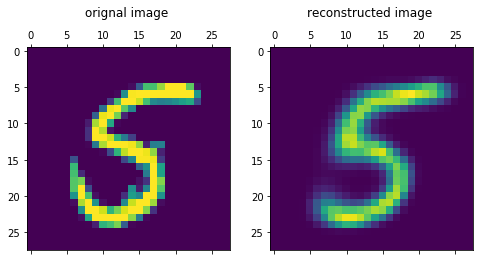

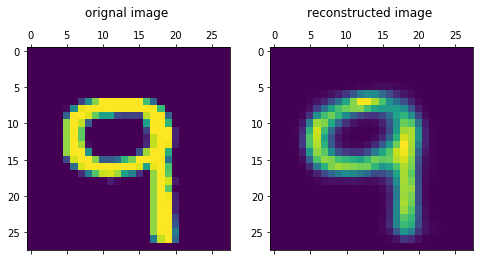

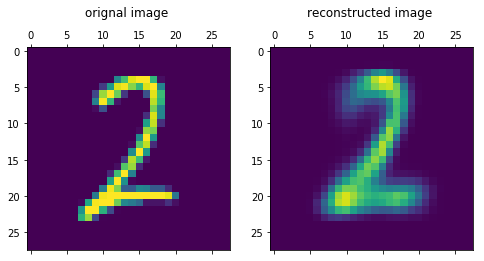

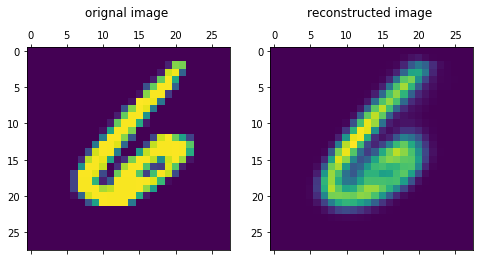

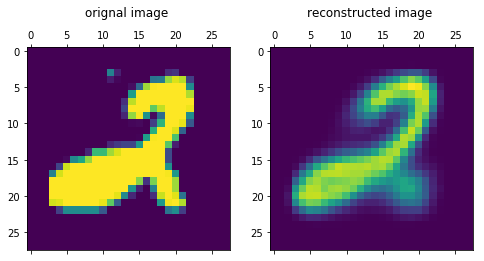

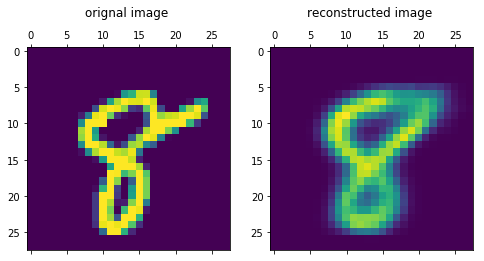

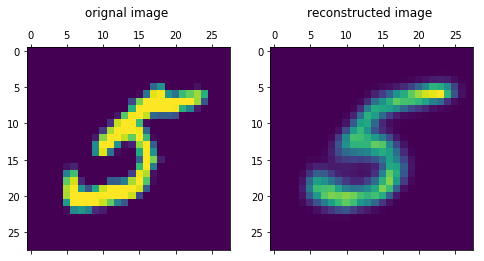

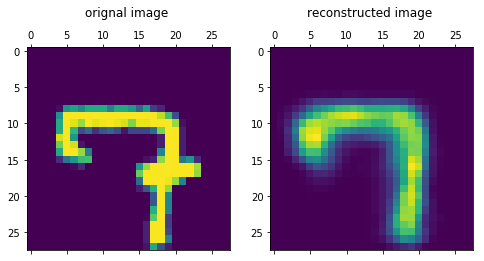

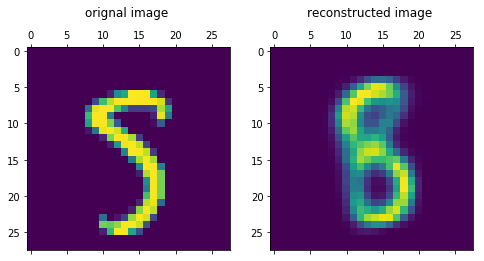

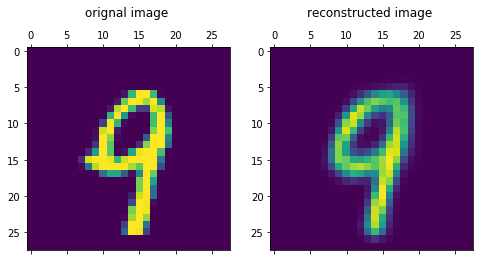

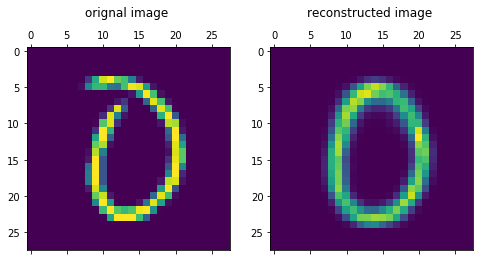

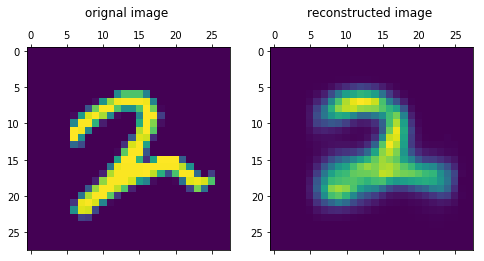

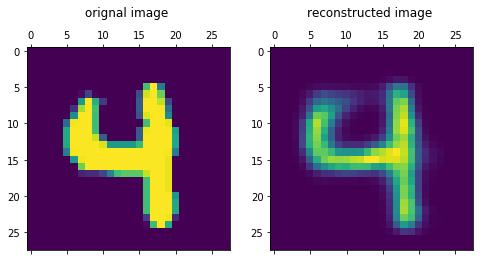

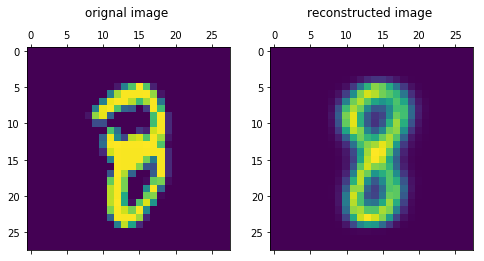

In [33]:
# Look at training images

image_mu = vae.forward(train_data['image'])[0]

figsize = 8
for i in range(0, 20): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(train_data['image'][i, :, :])
    axarr[1].matshow(image_mu[i, :, :].detach())
    
    axarr[0].set_title('orignal image \n')
    axarr[1].set_title('reconstructed image \n')

In [34]:
# check a few test images 

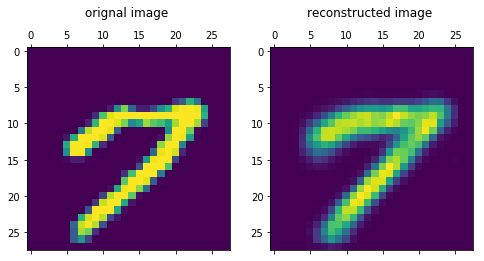

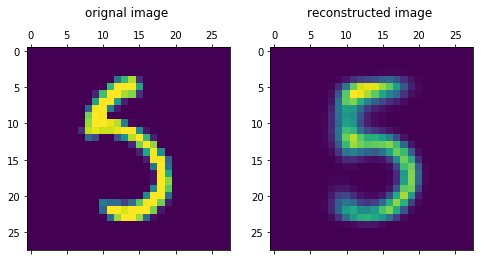

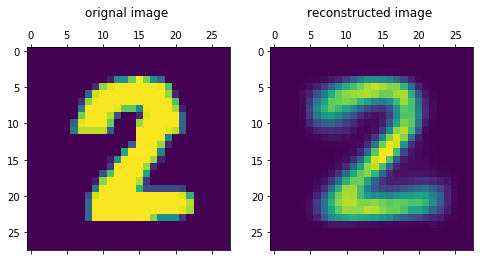

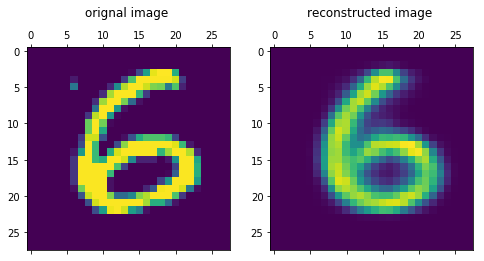

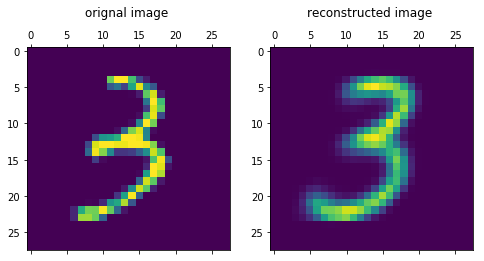

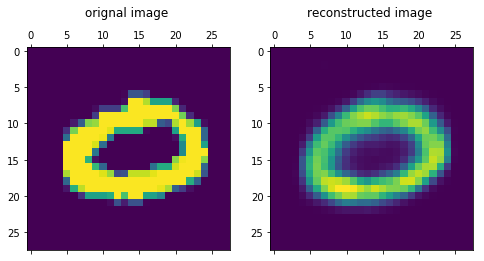

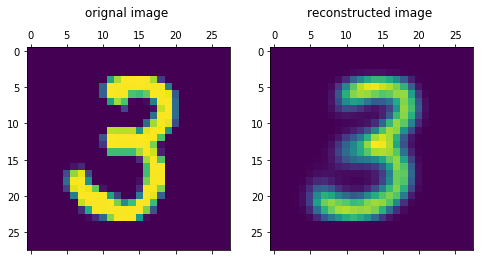

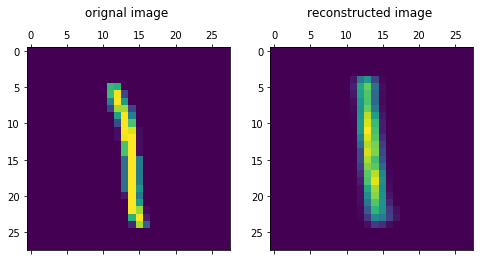

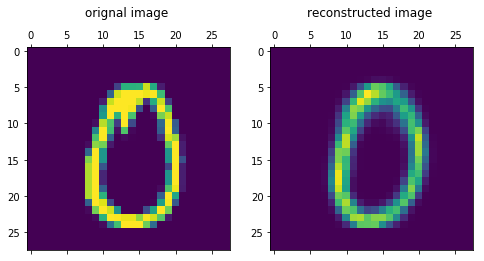

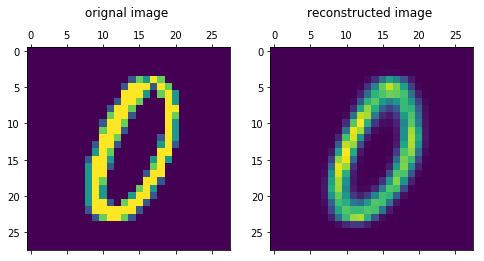

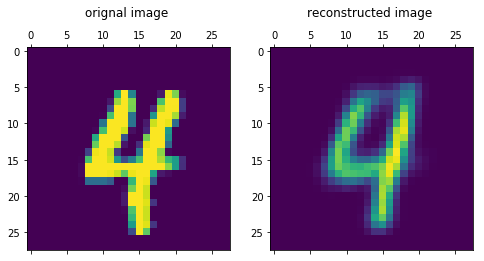

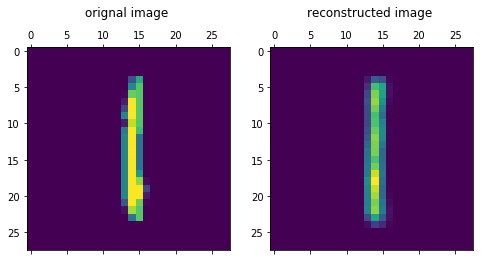

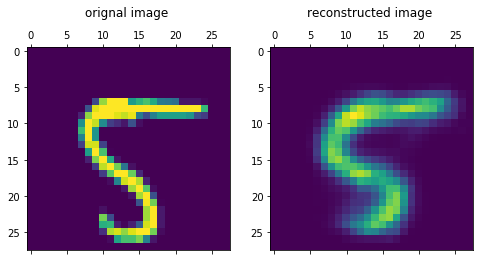

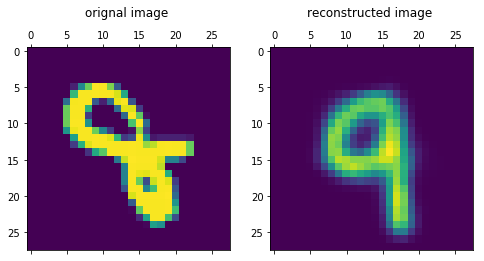

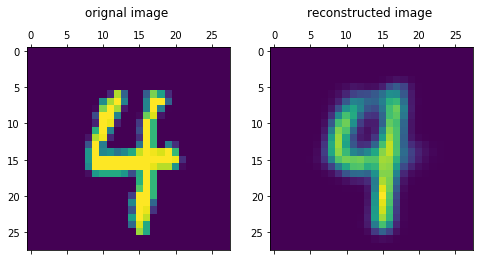

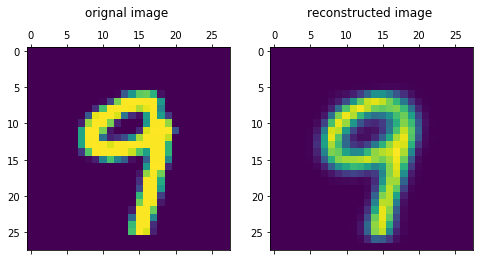

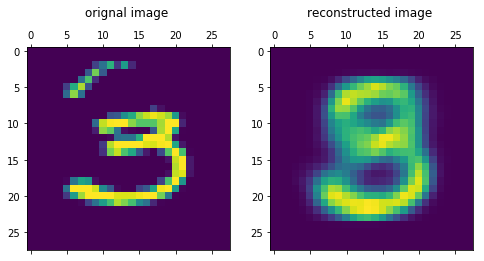

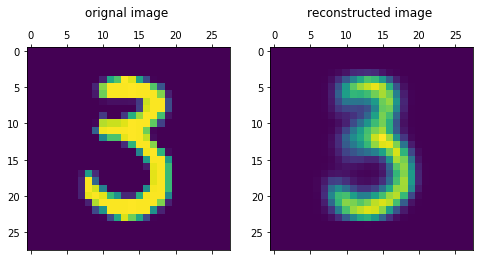

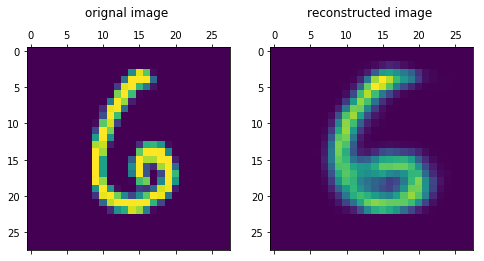

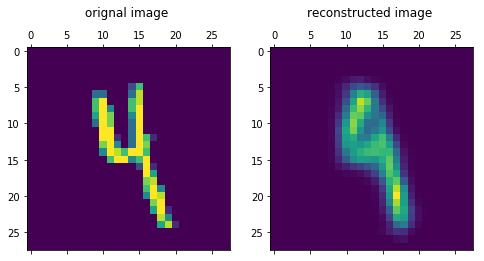

In [37]:
image_mu = vae.forward(test_data['image'])[0]

figsize = 8
for i in range(0, 20): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(test_data['image'][i, :, :])
    axarr[1].matshow(image_mu[i, :, :].detach())
    
    axarr[0].set_title('orignal image \n')
    axarr[1].set_title('reconstructed image \n')

# check conditional generation

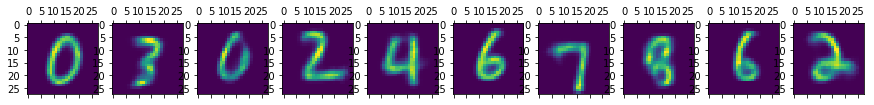

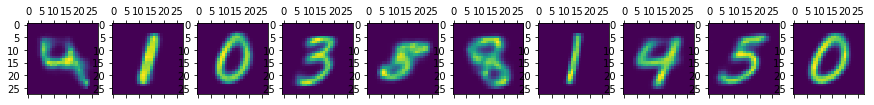

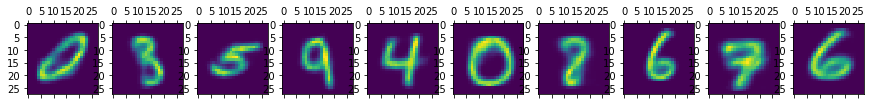

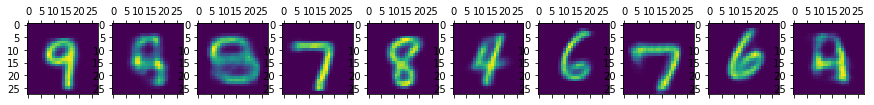

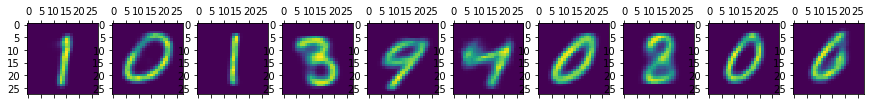

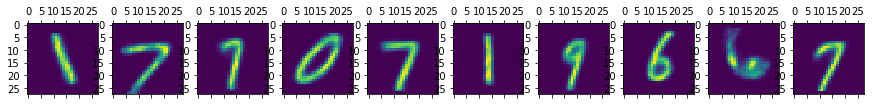

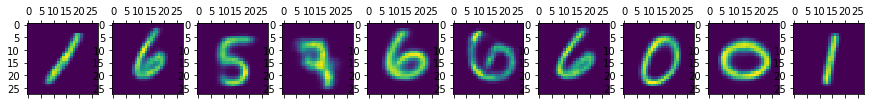

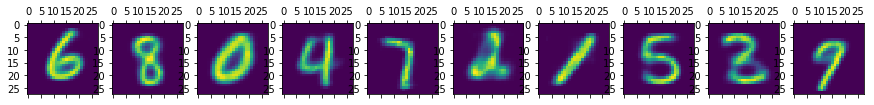

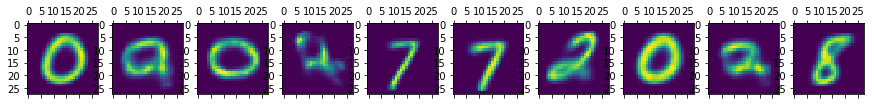

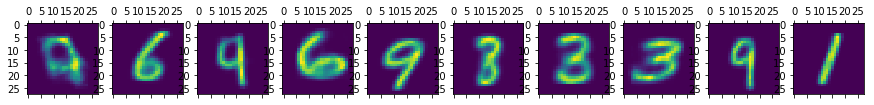

In [40]:
for k in range(10): 
    num = 10
    latent_params = torch.randn((num, latent_dim))

    recon_mean = vae.decoder.forward(latent_params, z = None)
    f, axarr = plt.subplots(1, num, figsize=(15, 15))

    for i in range(0, num): 
        axarr[i].matshow(recon_mean[i, :, :].detach())
